In [63]:
import numpy as np
import pandas as pd
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from collections import defaultdict
from yellowbrick.contrib.classifier import DecisionViz
from sklearn.decomposition import PCA
from itertools import product
from yellowbrick.datasets import load_credit
from yellowbrick.features import PCA as yPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from scikitplot.metrics import plot_precision_recall, plot_roc, plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report

In [2]:
# Dataset con attributi originali
df = pd.read_csv("dataset_All_normalized.csv")
class_name = 'Occupancy'

In [3]:
def result_pred(y_true, y_pred):
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

    # Calcolo dell'accuracy
    print("***** Calcolo dell'accuracy *****")
    accuracy = accuracy_score(y_true, y_pred)    
    print('Frazione di campioni correttamente correlati: %0.4f' % accuracy)
    accuracy = accuracy_score(y_true, y_pred, False)
    print("Numero di campioni correttamente correlati: ", accuracy)    
    print("____________________________________________")

    # Calcolo della precision
    print("**** Calcolo della precisione *****")
    #Percentuale di classificazioni positive che sono corrette
    #se dico "positivo" dico giusto?
    precision = precision_score(y_true, y_pred)
    print('Percentuale di classificazioni positive che sono corrette: %0.4f' % precision)   
    print("____________________________________________")    

    # Calcolo della recall
    print("**** Calcolo della recall (sensitivity) *****")
    recall = recall_score(y_true, y_pred)
    print('Percentuale di elementi positivi del testing set che sono stati classificati come positivi: %0.4f' % recall)
    print("____________________________________________")    

    # Calcolo della specificity
    print("**** Calcolo della specificity *****")
    specificity = tn / (tn+fp)
    print('Percentuale di elementi negativi del testing set che sono stati classificati come negativi: %0.4f' % specificity)
    print("____________________________________________")   
    
    # Calcolo dell'F1 score
    print("**** Calcolo della F1 score *****")
    f1 = f1_score(y_true, y_pred)
    #Il punteggio F1 può essere interpretato come una media ponderata della precisione e della recall, 
    #in cui un punteggio F1 raggiunge il suo valore migliore a 1 e il punteggio peggiore a 0.
    print('F1 scores: %0.4f' % f1)
    print("____________________________________________")   
    
    # Stampiamo le stesse statistiche dalla funzione report
    print(classification_report(y_test, y_pred))
    
    print("Con le tecniche viste finora non viene fornita nessuna informazione sulla “gravità” degli errori (“errore lieve” oppure “errore grave)")
    print("per questo si usano la curva CMC, la curva ROC")


In [4]:
def plot_res(y_pred, y_score, y_test):
    #ROC CURVE: implementazione legata esclusivamente all'attività di classificazione binaria
    #false positive rate, true positive rate
    print("****** ROC CURVE + AUC?: passo passo *******")
    fprate, tprate, threashold = roc_curve(y_test, y_score[:, 1])
    auc_score = auc(fprate, tprate)
    plt.plot(fprate, tprate, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=14, frameon=False)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.show()

    print("____________________________________")
    print("****** VALORE DI AUC *******")    
    print(roc_auc_score(y_test, y_score[:,1]))    
    
    print("____________________________________")
    print("****** ROC CURVE: con metodo diretto *******")
    plot_roc(y_test, y_score)
    plt.show()
    
    print("____________________________________")
    print("****** Precision recall: con metodo diretto *******")
    plot_precision_recall(y_test, y_score)
    plt.show()
    

    print("____________________________________")
    print("****** Cumulative gain: con metodo diretto *******")
    plot_cumulative_gain(y_test, y_score)
    plt.show()
    
    
    print("____________________________________")
    print("****** Lift curve: con metodo diretto *******")    
    plot_lift_curve(y_test, y_score)
    plt.show()

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from sklearn.model_selection import GridSearchCV

In [6]:
from keras.regularizers import l2


In [12]:
def f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    
    return 2*((prec*rec)/(prec+rec+K.epsilon()))
def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [7]:
def build_model_1(optimizer='adagrad'):
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(32, input_dim=n_feature, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    # Linear
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f1])
    return model

In [8]:
def build_model_2(optimizer='adam'):
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    # Linear
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f1])
    return model

In [17]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify=y)

In [18]:
model1 = build_model_1()
history1 = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=10).history

model2 = build_model_2()
history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=50).history

Train on 14392 samples, validate on 6168 samples
Epoch 1/30
14392/14392 [==============================] - 3s 187us/step - loss: 0.0525 - f1: 0.8964 - val_loss: 0.0496 - val_f1: 0.9074
Epoch 2/30
14392/14392 [==============================] - 2s 154us/step - loss: 0.0424 - f1: 0.9063 - val_loss: 0.0410 - val_f1: 0.9107
Epoch 3/30
14392/14392 [==============================] - 2s 156us/step - loss: 0.0412 - f1: 0.8949 - val_loss: 0.0400 - val_f1: 0.9107
Epoch 4/30
14392/14392 [==============================] - 2s 156us/step - loss: 0.0407 - f1: 0.9062 - val_loss: 0.0441 - val_f1: 0.9093
Epoch 5/30
14392/14392 [==============================] - 2s 156us/step - loss: 0.0402 - f1: 0.9085 - val_loss: 0.0395 - val_f1: 0.9109
Epoch 6/30
14392/14392 [==============================] - 2s 156us/step - loss: 0.0405 - f1: 0.9125 - val_loss: 0.0392 - val_f1: 0.9109
Epoch 7/30
14392/14392 [==============================] - 2s 156us/step - loss: 0.0400 - f1: 0.9066 - val_loss: 0.0391 - val_f1: 0.9109

14392/14392 [==============================] - 1s 36us/step - loss: 0.0344 - f1: 0.9798 - val_loss: 0.0311 - val_f1: 0.9776


In [19]:
test_loss_1, test_acc_1 = model1.evaluate(X_test, y_test)
test_loss_2, test_acc_2 = model2.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))

6168/6168 [==============================] - 0s 19us/step
Loss 0.037949, Accuracy 0.978759
Loss 0.031092, Accuracy 0.977636


# Deep Neural Network

In [20]:
y_pred1 = model1.predict_classes(X_test)
result_pred(y_test, y_pred)
y_score1 = model1.predict_proba(X_test)
#plot_res(y_pred, y_score, y_test)

y_pred2 = model2.predict_classes(X_test)
result_pred(y_test, y_pred)
y_score2 = model2.predict_proba(X_test)
#plot_res(y_pred, y_score, y_test)

**** Matrice di Confusione *****
 True negative: 4666 False negative: 0
 True positive: 1425 False positive: 77
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9875
Numero di campioni correttamente correlati:  6091
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9487
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 1.0000
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9838
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9737
____________________________________________
              precision    recall  f1-score   

# Single Perceptron 

**** Matrice di Confusione *****
 True negative: 4673 False negative: 0
 True positive: 1425 False positive: 70
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9887
Numero di campioni correttamente correlati:  6098
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9532
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 1.0000
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9852
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9760
____________________________________________
              precision    recall  f1-score   

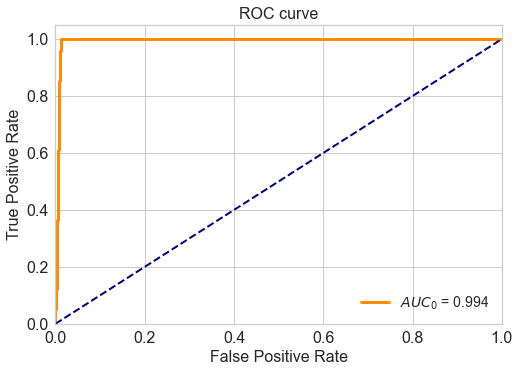

____________________________________
****** VALORE DI AUC *******
0.9940496613661499
____________________________________
****** ROC CURVE: con metodo diretto *******


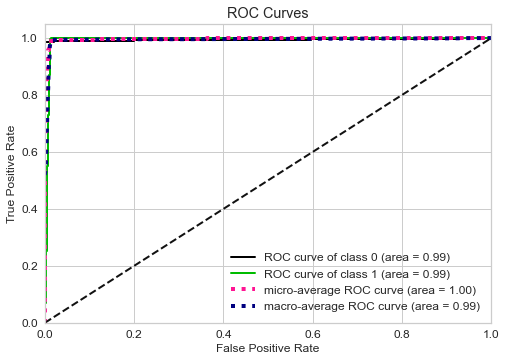

____________________________________
****** Precision recall: con metodo diretto *******


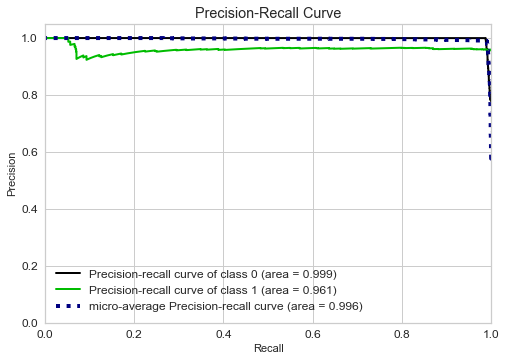

____________________________________
****** Cumulative gain: con metodo diretto *******


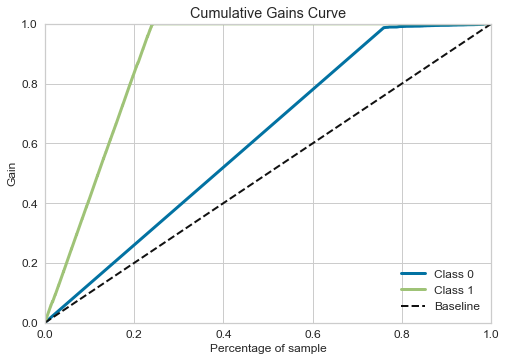

____________________________________
****** Lift curve: con metodo diretto *******


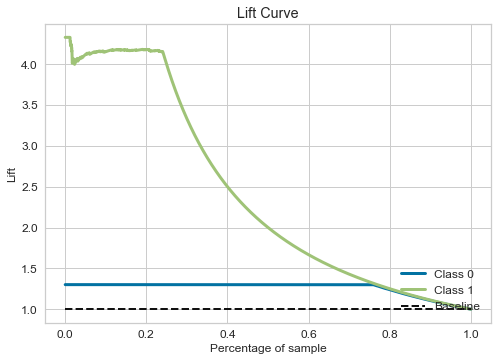

In [24]:
from sklearn.calibration import CalibratedClassifierCV
clf = Perceptron(alpha = 0.0003, penalty = "l1", tol=0.001)
clf.fit(X_train, y_train)
y_pred3 = clf.predict(X_test)
result_pred(y_test, y_pred3)
#y_score = clf.predict_proba(X_test)
cclf = CalibratedClassifierCV(base_estimator=Perceptron(alpha = 0.0003, penalty = "l1", tol=0.001), cv=5)
cclf.fit(X_train, y_train)
y_pred4 = cclf.predict(X_test)
y_score4 = cclf.predict_proba(X_test)
result_pred(y_test, y_pred4)
#plot_res_linearSVC(y_pred, y_score[:, 1], y_test)
plot_res(y_pred4, y_score4, y_test)

# Multilayer Perceptron

**** Matrice di Confusione *****
 True negative: 4683 False negative: 4
 True positive: 1421 False positive: 60
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9896
Numero di campioni correttamente correlati:  6104
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9595
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9972
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9873
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9780
____________________________________________
              precision    recall  f1-score   

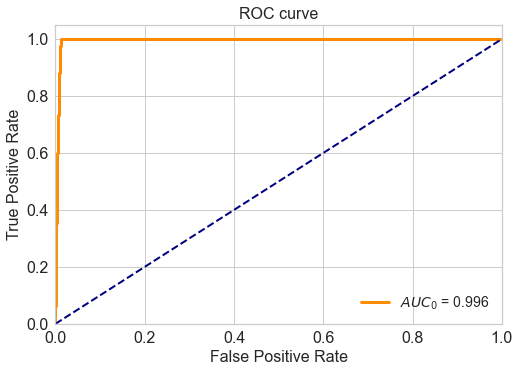

____________________________________
****** VALORE DI AUC *******
0.9956045289272093
____________________________________
****** ROC CURVE: con metodo diretto *******


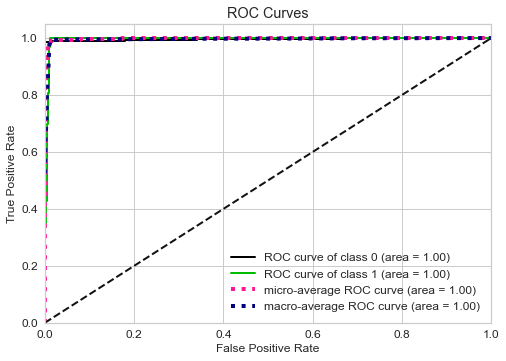

____________________________________
****** Precision recall: con metodo diretto *******


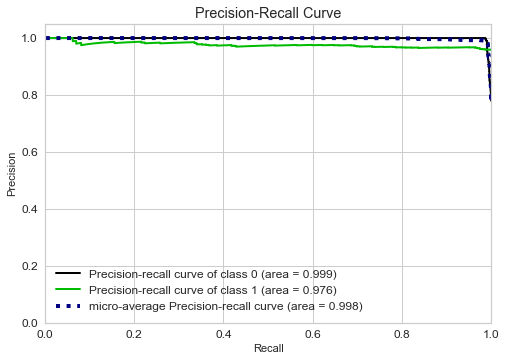

____________________________________
****** Cumulative gain: con metodo diretto *******


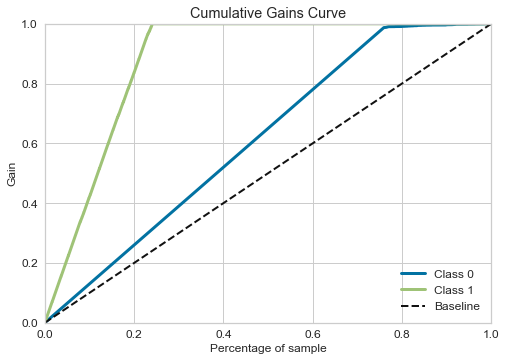

____________________________________
****** Lift curve: con metodo diretto *******


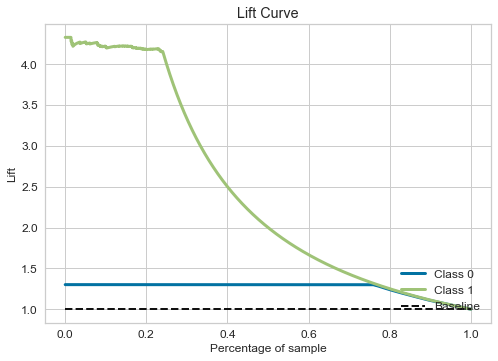

In [28]:
clf = MLPClassifier(solver = 'sgd', momentum = 0.9, learning_rate = 'adaptive' , hidden_layer_sizes=(12, 23, 11))
clf.fit(X_train, y_train)
y_pred5 = clf.predict(X_test)
result_pred(y_test, y_pred5)
#y_score = clf.predict_proba(X_test)
y_score5 = clf.predict_proba(X_test)
plot_res(y_pred5, y_score5, y_test)

# AdaBoost

****** ROC CURVE + AUC?: passo passo *******


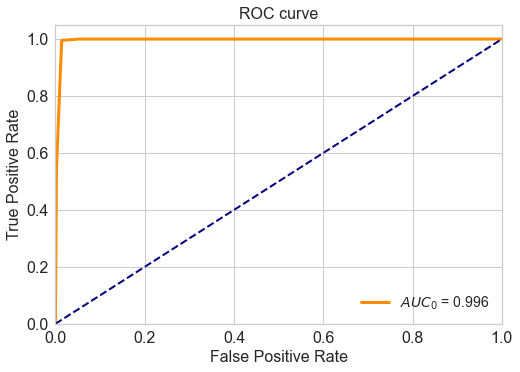

____________________________________
****** VALORE DI AUC *******
0.9955684277106429
____________________________________
****** ROC CURVE: con metodo diretto *******


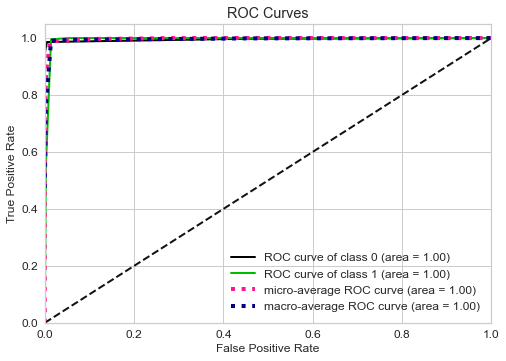

____________________________________
****** Precision recall: con metodo diretto *******


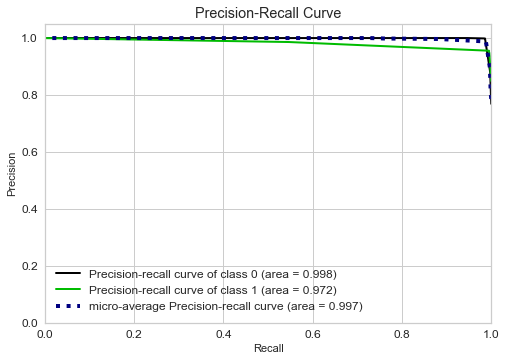

____________________________________
****** Cumulative gain: con metodo diretto *******


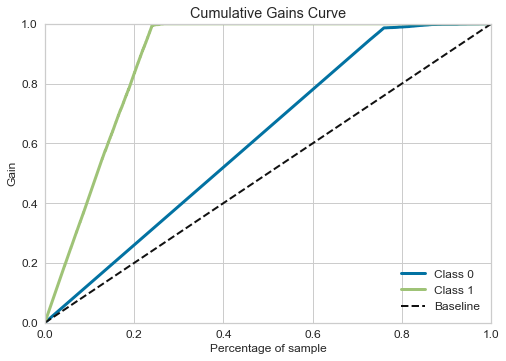

____________________________________
****** Lift curve: con metodo diretto *******


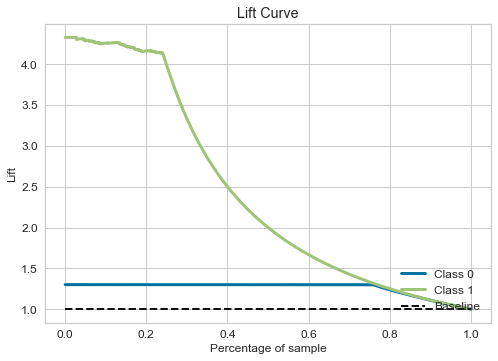

In [56]:
clf = AdaBoostClassifier(learning_rate= 0.5, n_estimators= 5)
clf.fit(X_train, y_train)
y_pred6 = clf.predict(X_test)
y_score6 = clf.predict_proba(X_test)
plot_res(y_pred6, y_score6, y_test)

# Random Forest 

**** Matrice di Confusione *****
 True negative: 4715 False negative: 15
 True positive: 1410 False positive: 28
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9930
Numero di campioni correttamente correlati:  6125
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9805
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9895
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9941
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9850
____________________________________________
              precision    recall  f1-score  

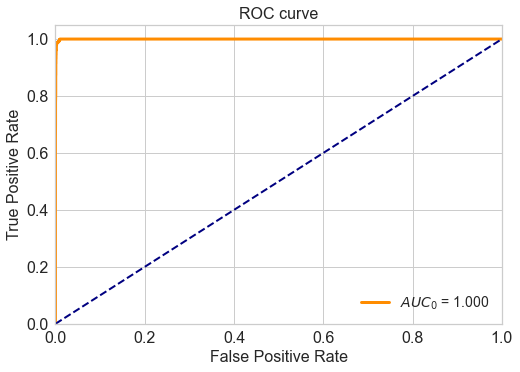

____________________________________
****** VALORE DI AUC *******
0.9996682091059401
____________________________________
****** ROC CURVE: con metodo diretto *******


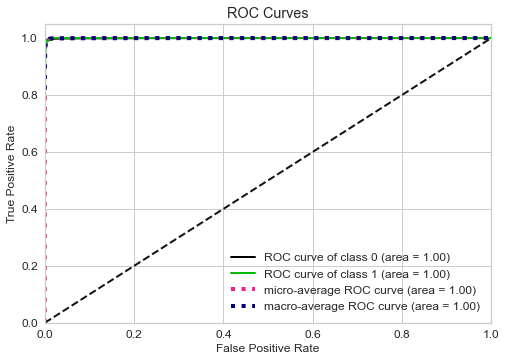

____________________________________
****** Precision recall: con metodo diretto *******


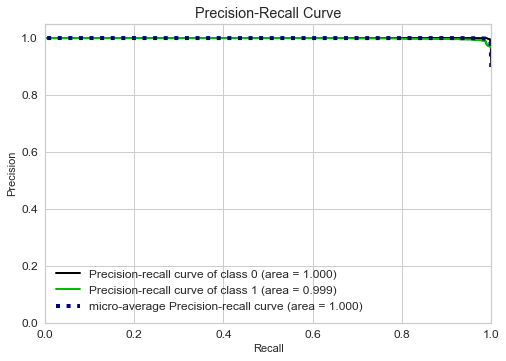

____________________________________
****** Cumulative gain: con metodo diretto *******


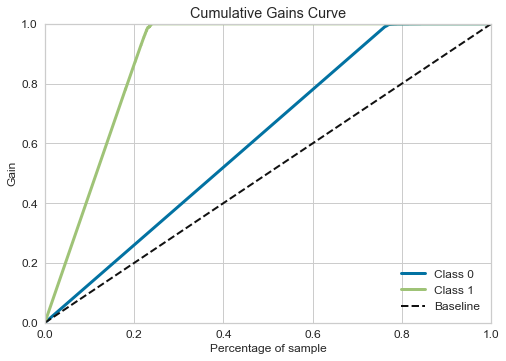

____________________________________
****** Lift curve: con metodo diretto *******


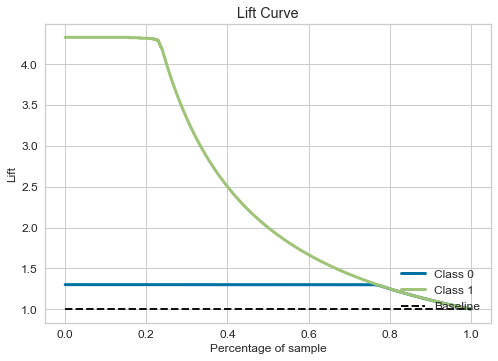

In [61]:
clf = RandomForestClassifier(n_estimators = 500)
clf.fit(X_train, y_train)
y_pred7 = clf.predict(X_test)
result_pred(y_test, y_pred7)
y_score7 = clf.predict_proba(X_test)
plot_res(y_pred7, y_score7, y_test)

# Ensemble

**** Matrice di Confusione *****
 True negative: 4027 False negative: 0
 True positive: 1425 False positive: 716
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.8839
Numero di campioni correttamente correlati:  5452
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.6656
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 1.0000
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.8490
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.7992
____________________________________________
              precision    recall  f1-score  

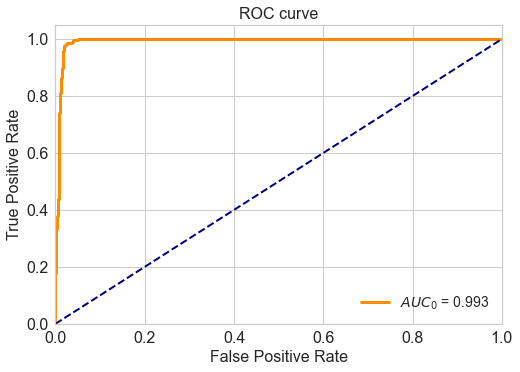

____________________________________
****** VALORE DI AUC *******
0.9927927767975706
____________________________________
****** ROC CURVE: con metodo diretto *******


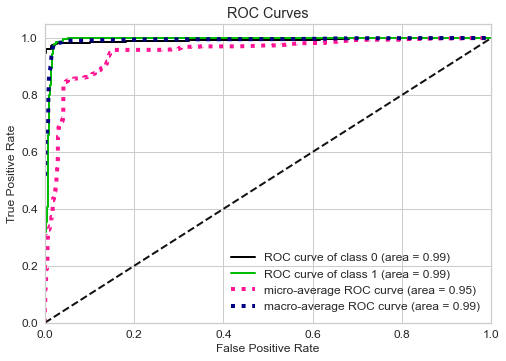

____________________________________
****** Precision recall: con metodo diretto *******


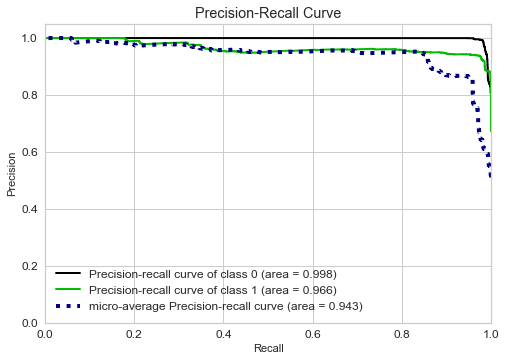

____________________________________
****** Cumulative gain: con metodo diretto *******


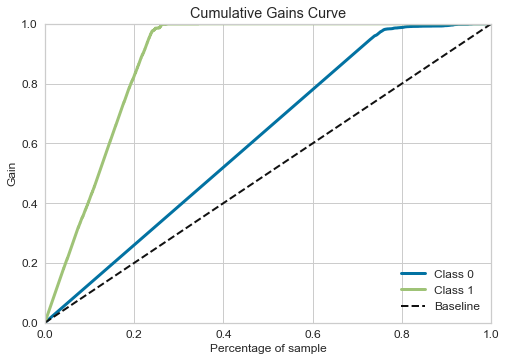

____________________________________
****** Lift curve: con metodo diretto *******


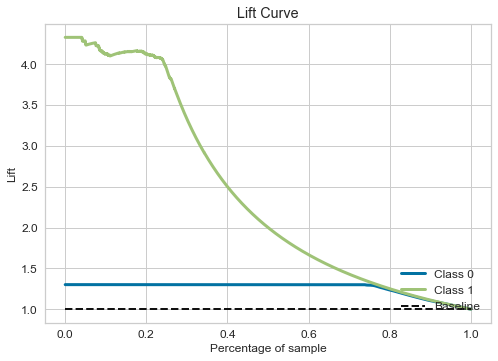

In [64]:
clf = BaggingClassifier(GaussianNB(), max_features = 2, max_samples = 0.01, n_estimators = 100)
clf.fit(X_train, y_train)
y_pred8 = clf.predict(X_test)
result_pred(y_test, y_pred8)
y_score8 = clf.predict_proba(X_test)
plot_res(y_pred8, y_score8, y_test)

# ROC CURVE - CUMULATIVA

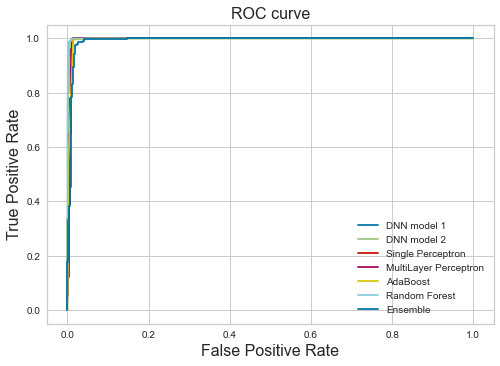

In [65]:
plt.figure(0)


fpr, tpr, thresh =roc_curve(y_test, y_score1)
#auc_score = auc(fpr, tpr)

plt.plot(fpr,tpr,label="DNN model 1")#, auc="+str(auc_score))

fpr, tpr, thresh =roc_curve(y_test, y_score2)
#auc_score = auc(fpr, tpr)

plt.plot(fpr,tpr,label="DNN model 2")#, auc="+str(auc_score))

fpr, tpr, thresh =roc_curve(y_test, y_score4[:, 1])
#auc_score = auc(fpr, tpr)

plt.plot(fpr,tpr,label="Single Perceptron")#, auc="+str(auc_score))

fpr, tpr, thresh =roc_curve(y_test, y_score5[:, 1])
#auc_score = auc(fpr, tpr)

plt.plot(fpr,tpr,label="MultiLayer Perceptron")#, auc="+str(auc_score))

fpr, tpr, thresh =roc_curve(y_test, y_score6[:, 1])
#auc_score = auc(fpr, tpr)

plt.plot(fpr,tpr,label="AdaBoost")#, auc="+str(auc_score))

fpr, tpr, thresh =roc_curve(y_test, y_score7[:, 1])
#auc_score = auc(fpr, tpr)

plt.plot(fpr,tpr,label="Random Forest")#, auc="+str(auc_score))

fpr, tpr, thresh =roc_curve(y_test, y_score8[:, 1])
#auc_score = auc(fpr, tpr)

plt.plot(fpr,tpr,label="Ensemble")#, auc="+str(auc_score))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc=0)


# LIFT CURVE - CUMULATIVO

Spiegazione Lift

https://towardsdatascience.com/the-lift-curve-unveiled-998851147871

In [86]:
def plot_Lift_curve(y_val, y_pred, step=0.01):
    
    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    
    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []
    
    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number 
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
    return x_val, y_v


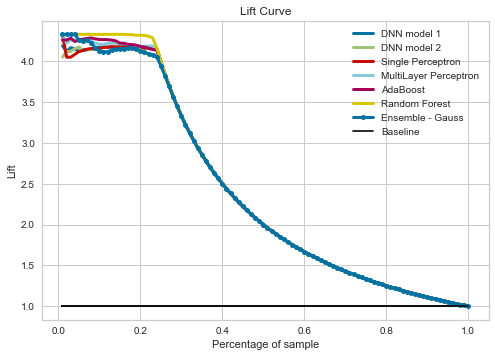

In [102]:
x_val1, y_v1=plot_Lift_curve(y_test, y_pred1)
x_val2, y_v2=plot_Lift_curve(y_test, y_pred2)
x_val4, y_v4=plot_Lift_curve(y_test, y_score4[:, 1])
x_val5, y_v5 =plot_Lift_curve(y_test, y_score5[:, 1])
x_val6, y_v6 =plot_Lift_curve(y_test, y_score6[:, 1])
x_val7, y_v7 =plot_Lift_curve(y_test, y_score7[:, 1])
x_val8, y_v8 =plot_Lift_curve(y_test, y_score8[:, 1])

#Plot the figure
fig, axis = plt.subplots()
fig.figsize = (40,40)

axis.plot(x_val1, y_v1, 'b-', linewidth = 3, markersize = 5, label="DNN model 1")
axis.plot(x_val1, np.ones(len(x_val1)), 'k-')

axis.plot(x_val2, y_v2, 'g-', linewidth = 3, markersize = 5, label="DNN model 2")
axis.plot(x_val2, np.ones(len(x_val2)), 'k-')

axis.plot(x_val4, y_v4, 'r-', linewidth = 3, markersize = 5, label="Single Perceptron")
axis.plot(x_val4, np.ones(len(x_val4)), 'k-')

axis.plot(x_val5, y_v5, 'c-', linewidth = 3, markersize = 5, label="MultiLayer Perceptron")
axis.plot(x_val5, np.ones(len(x_val5)), 'k-')


axis.plot(x_val6, y_v6, 'm-', linewidth = 3, markersize = 5, label="AdaBoost")
axis.plot(x_val6, np.ones(len(x_val6)), 'k-')


axis.plot(x_val7, y_v7, 'y-', linewidth = 3, markersize = 5, label="Random Forest")
axis.plot(x_val7, np.ones(len(x_val7)), 'k-')


axis.plot(x_val8, y_v8, 'o-', linewidth = 3, markersize = 5, label="Ensemble - Gauss")
axis.plot(x_val8, np.ones(len(x_val8)), 'k-', label="Baseline")

axis.set_xlabel('Percentage of sample')
axis.set_ylabel('Lift')
plt.title('Lift Curve')
plt.legend(loc=0)

plt.show()
